In [14]:
import pandas as pd
import os
import re
import nltk
import subprocess
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%pip install wordcloud
%pip install sastrawi
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import matplotlib.pyplot as plt


nltk.download('punkt')
nltk.download('stopwords')

# ==== Load Stopwords ====
def load_stopwords(file_path):
    stopwords_list = set(stopwords.words("indonesian"))
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            additional_stopwords = {line.strip() for line in f.readlines()}
        stopwords_list.update(additional_stopwords)
    except Exception as e:
        print(f"Error loading stopword list from file: {e}")
    return stopwords_list

stop_words = load_stopwords("stopwords.txt")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# ==== Scraper YouTube ====
def scrape_youtube_comments(url, limit=300):
    output_file = "comments.csv"
    if os.path.exists(output_file):
        os.remove(output_file)
    cmd = [
        "youtube-comment-downloader",
        "--url", url,
        "--output", output_file,
        "--limit", str(limit)
    ]
    subprocess.run(cmd)
    return pd.read_csv(output_file, on_bad_lines='skip', quoting=3, encoding='utf-8')

# ==== Preprocessing ====
def get_root_words(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    return [stemmer.stem(w) for w in words if w not in stop_words and len(w) > 1]

def clean_text(text):
    return " ".join(get_root_words(text))

# ==== Sentiment Analysis ====
def load_lexicon(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return set(line.strip() for line in f.readlines())
    except Exception as e:
        print(f"Error loading lexicon from {file_path}: {e}")
        return set()

positive_words = load_lexicon("positif.txt")
negative_words = load_lexicon("negatif.txt")

def get_sentiment(text):
    words = text.split()
    pos = sum(1 for w in words if w in positive_words)
    neg = sum(1 for w in words if w in negative_words)
    if pos > neg:
        return "Positif"
    elif neg > pos:
        return "Negatif"
    else:
        return "Netral"

# ==== Load Emotion Lexicon ====
def load_emotion_lexicon(file_path):
    emotions = {}
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                if ":" in line:
                    emotion, words = line.strip().split(":")
                    emotions[emotion.strip()] = set(w.strip() for w in words.split(","))
    except Exception as e:
        print(f"Error loading emotion lexicon from {file_path}: {e}")
    return emotions

emotion_lexicon = load_emotion_lexicon("emosi.txt")

def get_emotion(text):
    words = text.split()
    scores = {e: 0 for e in emotion_lexicon}
    for word in words:
        for emotion, wordlist in emotion_lexicon.items():
            if word in wordlist:
                scores[emotion] += 1
    if not any(scores.values()):
        return "Netral"
    return max(scores, key=scores.get)

# ==== Main Analysis ====
url = input("Enter the YouTube video URL: ")
limit = int(input("Enter the number of comments to scrape (e.g., 300): "))

df = scrape_youtube_comments(url, limit)
comment_col = next((col for col in df.columns if "text" in col.lower() or "comment" in col.lower()), None)

if not comment_col:
    print("Comment column not found.")
else:
    df["root_words"] = df[comment_col].astype(str).apply(get_root_words)
    df["clean_text"] = df["root_words"].apply(lambda x: " ".join(x))
    df = df[df["clean_text"].str.strip() != ""]
    df["sentimen"] = df["clean_text"].apply(get_sentiment)
    df["emosi"] = df["clean_text"].apply(get_emotion)

    # ==== Sentiment Chart ====
    counts = df["sentimen"].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title("Sentiment Distribution")
    plt.ylabel("Number of Comments")
    plt.xlabel("Sentiment")
    plt.show()

    # ==== Emotion Chart ====
    emotion_counts = df["emosi"].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="coolwarm")
    plt.title("Emotion Distribution")
    plt.ylabel("Number of Comments")
    plt.xlabel("Emotion")
    plt.show()

    # ==== Topic Modeling ====
    vectorizer = CountVectorizer(max_df=0.9, min_df=2)
    X = vectorizer.fit_transform(df["clean_text"])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)

    vocab = vectorizer.get_feature_names_out()
    combined_word_freq = {}

    for i, topic in enumerate(lda.components_):
        top_idx = topic.argsort()[:-11:-1]
        top_words = [(vocab[j], topic[j]) for j in top_idx]
        print(f"Topic {i+1}: {', '.join(w for w, _ in top_words)}")
        for w, score in top_words:
            combined_word_freq[w] = combined_word_freq.get(w, 0) + score

    # ==== Word Cloud ====
    wc = WordCloud(width=800, height=500, background_color="white").generate_from_frequencies(combined_word_freq)
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\saefu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl.metadata (909 bytes)
Using cached Sastrawi-1.0.1-py2.py3-none-any.whl (209 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\saefu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saefu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saefu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: invalid literal for int() with base 10: ''

In [ ]:
!pip install youtube-comment-downloader
!pip install pandas numpy matplotlib seaborn nltk
!pip install bertopic sentence-transformers
!pip install scikit-learn


In [1]:
import subprocess
import pandas as pd

In [12]:
import sys

def download_comments(video_url):
    subprocess.run([
        sys.executable, "-m", "youtube_comment_downloader",
        "--url", video_url,
        "--output", "comments.csv",
        "--limit", "500"
    ])

# URL youtube 
download_comments("https://www.youtube.com/watch?v=SzXMacu80o8")

In [3]:
# 2. Load & Preprocessing
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv("comments.csv", on_bad_lines="skip", quoting=3, encoding="utf-8")
df = df.iloc[:, [0, 2, 3, 1]]  
df.columns = ['id', 'author', 'text', 'time']
df = df.dropna(subset=["text"])  
print(df.columns)
stop_words = set(stopwords.words("indonesian"))

Index(['id', 'author', 'text', 'time'], dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saefu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus angka dan simbol
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text
df["clean_text"] = df["text"].apply(clean_text)

In [5]:
# 3. Analisis Sentimen (pakai model ringan - TextBlob)
#%pip install textblob
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    score = analysis.sentiment.polarity
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["clean_text"].apply(get_sentiment)

In [6]:
# 4. Pemodelan Topik dengan BERTopic
#%pip install bertopic
from bertopic import BERTopic

# Pastikan kamu install model bahasa Indonesia jika ingin hasil lebih relevan
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

topic_model = BERTopic(embedding_model=model, language="multilingual")
topics, probs = topic_model.fit_transform(df["clean_text"])

df["topic"] = topics

C:\Users\saefu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


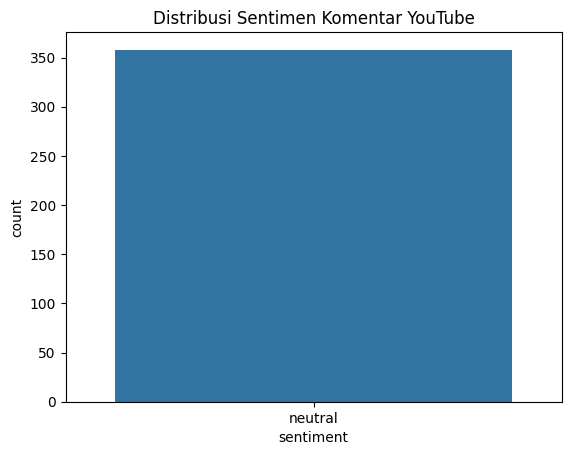

In [7]:
# 5. Visualisasi dasar
import matplotlib.pyplot as plt
import seaborn as sns

# Sentimen distribution
sns.countplot(data=df, x="sentiment")
plt.title("Distribusi Sentimen Komentar YouTube")
plt.show()

In [10]:
# Topik paling umum
df_topic_count = df['topic'].value_counts().reset_index()
df_topic_count.columns = ['topic', 'count']
print("\nTopik Paling Umum:")
print(df_topic_count.head())

# Tampilkan kata kunci dari tiap topik
topic_info = topic_model.get_topic_info()
print("\nTopik & Kata Kunci:")
print(topic_info)

# Visualisasi interaktif topik
#topic_model.visualize_topics().show()

# Ensure nbformat is installed and updated
%pip install --upgrade nbformat

# Import nbformat to ensure compatibility
import nbformat

fig = topic_model.visualize_topics(top_n_topics=5)
fig.show()


Topik Paling Umum:
   topic  count
0     -1    132
1      0     95
2      1     55
3      2     30
4      3     27

Topik & Kata Kunci:
   Topic  Count                                               Name  \
0     -1    132          -1_author_xiuyz_carlorockrm_nanyfidyawati   
1      0     95    0_author_donigaming_arifsantoso_ridasoulfounded   
2      1     55  1_author_candrayuliantozi_adamyusufadamsengine...   
3      2     30    2_author_sukamto_gibranganjarvy_nailairumahajar   
4      3     27               3_indriar_exxoman_debyprastio_author   
5      4     19              4_eliogkk_author_agunsapese_agustsiam   

                                      Representation  \
0  [author, xiuyz, carlorockrm, nanyfidyawati, mr...   
1  [author, donigaming, arifsantoso, ridasoulfoun...   
2  [author, candrayuliantozi, adamyusufadamsengin...   
3  [author, sukamto, gibranganjarvy, nailairumaha...   
4  [indriar, exxoman, debyprastio, author, intiwi...   
5  [eliogkk, author, agunsapese, agu


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\saefu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed